In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import current_timestamp

# Initialize Spark session
spark = SparkSession.builder.appName("SocialMediaSentimentAnalysis").getOrCreate()

# Load dataset
df = spark.read.csv("C:\\Users\\S566638\\Downloads\\sentimentdataset.csv", header=True, inferSchema=True)

# Simulate real-time processing by iterating through chunks
chunk_size = 5  # Number of rows to process at a time
total_rows = df.count()

print(f"Total rows in the dataset: {total_rows}")
print(f"Processing {chunk_size} rows at a time...\n")

for i in range(0, total_rows, chunk_size):
    # Select the next chunk of data
    chunk_df = df.limit(i + chunk_size).subtract(df.limit(i))
    
    # Add a timestamp to indicate when the data is processed
    chunk_df = chunk_df.withColumn("ProcessedTime", current_timestamp())
    
    print(f"Processing chunk {i//chunk_size + 1}...\n")
    chunk_df.show(truncate=False)

print("Real-time processing simulation completed!")


Total rows in the dataset: 732
Processing 5 rows at a time...

Processing chunk 1...

+---+----------+----------------------------------------------------+-----------+-------------------+--------------+-----------+------------------------------------------+--------+-----+------------+----+-----+---+----+--------------------------+
|_c0|Unnamed: 0|Text                                                |Sentiment  |Timestamp          |User          |Platform   |Hashtags                                  |Retweets|Likes|Country     |Year|Month|Day|Hour|ProcessedTime             |
+---+----------+----------------------------------------------------+-----------+-------------------+--------------+-----------+------------------------------------------+--------+-----+------------+----+-----+---+----+--------------------------+
|0  |0         | Enjoying a beautiful day at the park!              | Positive  |2023-01-15 12:30:00| User123      | Twitter   | #Nature #Park                            |15

In [ ]:
#goal2 :-  Sentiment Classification using Simple Rules

In [13]:
from pyspark.sql.functions import when

df = df.withColumn("SentimentClass", 
                   when((col("Likes") > 10) & (col("Retweets") > 10), "Positive")
                   .otherwise("Negative"))

df.select("Text", "Likes", "Retweets", "SentimentClass").show(5)


+--------------------+-----+--------+--------------+
|                Text|Likes|Retweets|SentimentClass|
+--------------------+-----+--------+--------------+
| Enjoying a beaut...| 30.0|    15.0|      Positive|
| Traffic was terr...| 10.0|     5.0|      Negative|
| Just finished an...| 40.0|    20.0|      Positive|
| Excited about th...| 15.0|     8.0|      Negative|
| Trying out a new...| 25.0|    12.0|      Positive|
+--------------------+-----+--------+--------------+
only showing top 5 rows



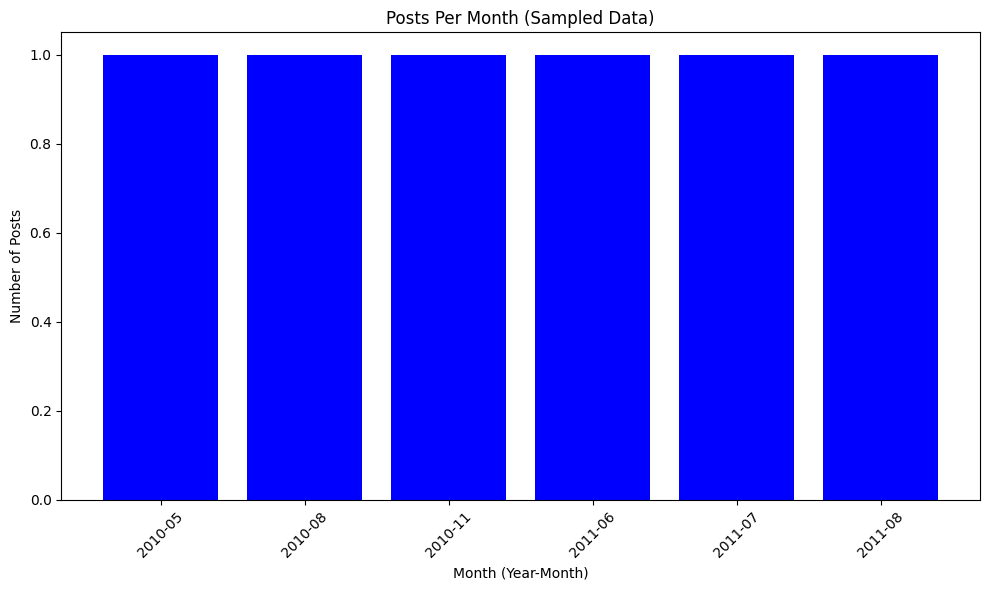

In [24]:
# goal 3 : Scalability & Resilence 
from pyspark.sql import SparkSession
from pyspark.sql.functions import year, month
import matplotlib.pyplot as plt

# Initialize Spark session
spark = SparkSession.builder.appName("Goal1_Scalability").getOrCreate()

# Load dataset
csv_file_path = "C:\\Users\\S566638\\Downloads\\sentimentdataset.csv"
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Select a subset of records
df_sample = df.limit(1000)

# Count posts per month
df_month_counts = df_sample.groupBy(year("Timestamp").alias("Year"), month("Timestamp").alias("Month")).count()
month_data = df_month_counts.orderBy("Year", "Month").limit(6).collect()

# Prepare data for visualization
months = [f"{row['Year']}-{row['Month']:02d}" for row in month_data]
post_counts = [row['count'] for row in month_data]

# Visualize with bar chart
plt.figure(figsize=(10, 6))
plt.bar(months, post_counts, color='blue')
plt.title('Posts Per Month (Sampled Data)')
plt.xlabel('Month (Year-Month)')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


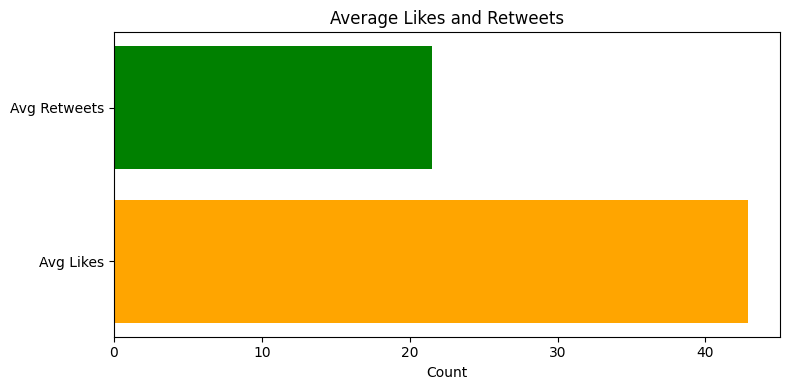

In [25]:
# goal 4 : Data storage & Retreival 

from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Compute averages
df_averages = df_sample.agg(
    F.avg("Likes").alias("AvgLikes"),
    F.avg("Retweets").alias("AvgRetweets")
)
average_data = df_averages.collect()
avg_likes = average_data[0]["AvgLikes"]
avg_retweets = average_data[0]["AvgRetweets"]

# Prepare data for visualization
labels = ["Avg Likes", "Avg Retweets"]
values = [avg_likes, avg_retweets]

# Visualize with horizontal bar chart
plt.figure(figsize=(8, 4))
plt.barh(labels, values, color=['orange', 'green'])
plt.title('Average Likes and Retweets')
plt.xlabel('Count')
plt.tight_layout()
plt.show()


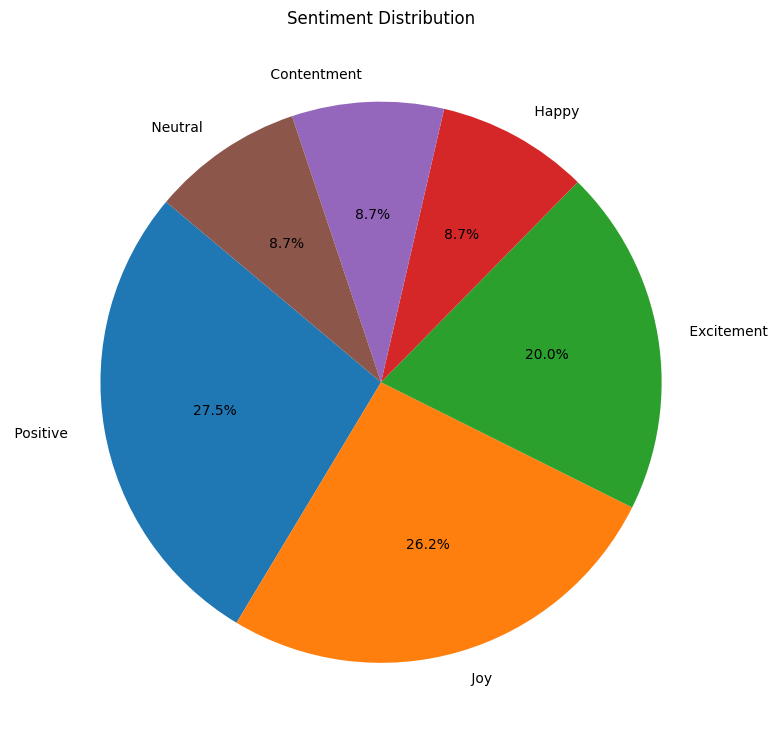

In [26]:
# goal 5:  Trend Analysis:
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Count posts by sentiment
df_sentiment_trends = df_sample.groupBy("Sentiment").count().orderBy("count", ascending=False).limit(6)
sentiment_data = df_sentiment_trends.collect()

# Prepare data for visualization
sentiments = [row['Sentiment'] for row in sentiment_data]
counts = [row['count'] for row in sentiment_data]

# Visualize with pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=sentiments, autopct='%1.1f%%', startangle=140, colors=plt.cm.tab10.colors)
plt.title('Sentiment Distribution')
plt.tight_layout()
plt.show()


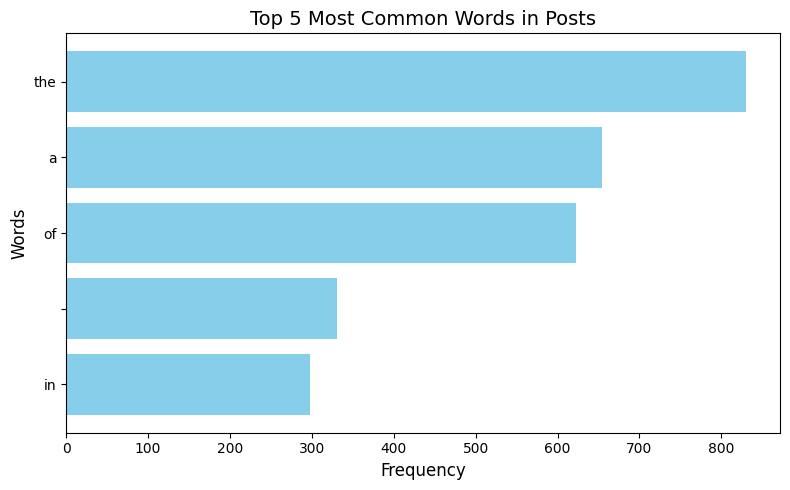

In [11]:
#goal 6: Find the Most Common Words in Posts 
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer
from pyspark.sql.functions import col, explode
import matplotlib.pyplot as plt
# Step 1: Initialize a Spark session
spark = SparkSession.builder.appName("CommonWordsVisualization").getOrCreate()
# Step 2: Load the CSV file into a DataFrame
csv_file_path = "C:\\Users\\S566638\\Downloads\\sentimentdataset.csv"  # Replace with the correct path
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)
# Step 3: Tokenize the text into words
tokenizer = Tokenizer(inputCol="Text", outputCol="Words")
df_tokens = tokenizer.transform(df)
# Step 4: Explode the list of words into individual rows and count the frequency of each word
df_words = (
    df_tokens
    .withColumn("Word", explode(col("Words")))
    .groupBy("Word")
    .count()
    .orderBy("count", ascending=False)
)
# Step 5: Collect the top 5 most common words and their counts
top_words = df_words.limit(5).collect()
words = [row['Word'] for row in top_words]
counts = [row['count'] for row in top_words]
# Step 6: Visualize the data using Matplotlib
plt.figure(figsize=(8, 5))
# Create a horizontal bar chart
plt.barh(words, counts, color='skyblue')
# Add titles and labels
plt.title('Top 5 Most Common Words in Posts', fontsize=14)
plt.xlabel('Frequency', fontsize=12)
plt.ylabel('Words', fontsize=12)
# Reverse the order of words for better readability
plt.gca().invert_yaxis()
# Show the plot
plt.tight_layout()
plt.show()


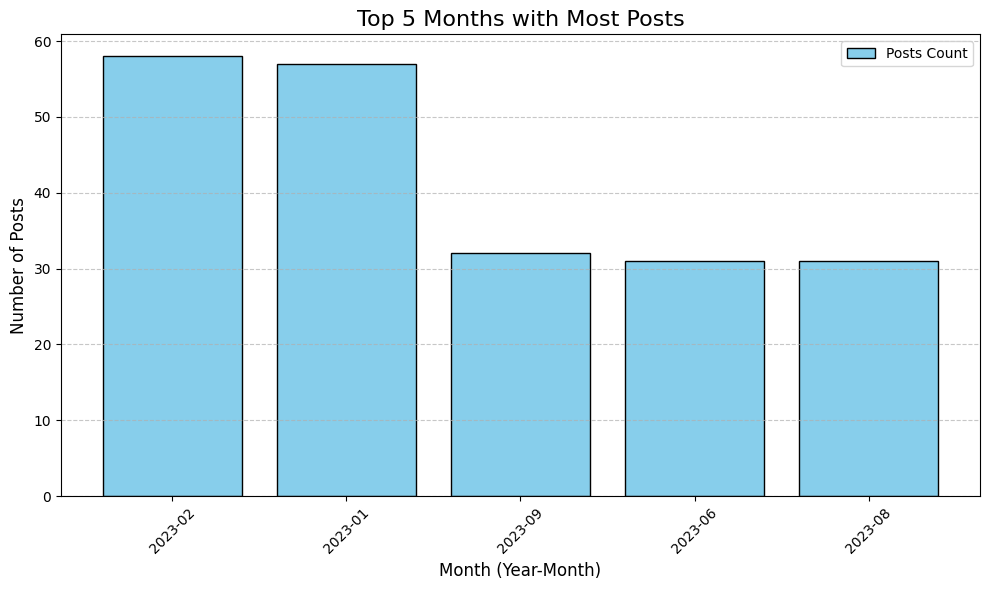

In [18]:
#goal 5: Count the Number of Posts per Month

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Step 1: Initialize a Spark session
spark = SparkSession.builder.appName("PostsPerMonthTop5").getOrCreate()

# Step 2: Load the CSV file into a DataFrame
csv_file_path = "C:\\Users\\S566638\\Downloads\\sentimentdataset.csv"  # Replace with the correct path
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Step 3: Count the number of posts per month
df_month_counts = df.groupBy("Year", "Month").count().orderBy("count", ascending=False).limit(5)

# Step 4: Collect the data for visualization
month_counts = df_month_counts.collect()
months = [f"{row['Year']}-{row['Month']:02d}" for row in month_counts]  # Format as Year-Month
post_counts = [row['count'] for row in month_counts]

# Step 5: Visualize the data using Matplotlib (Bar Chart)
plt.figure(figsize=(10, 6))
# Create a bar chart
plt.bar(months, post_counts, color='skyblue', edgecolor='black', label='Posts Count')

# Add titles and labels
plt.title('Top 5 Months with Most Posts', fontsize=16)
plt.xlabel('Month (Year-Month)', fontsize=12)
plt.ylabel('Number of Posts', fontsize=12)

# Rotate x-axis labels for readability
plt.xticks(rotation=45, fontsize=10)

# Add grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout and display the plot
plt.tight_layout()
plt.legend()
plt.show()

+---+----------+--------------------+-----------+-------------------+--------------+-----------+--------------------+--------+-----+------------+----+-----+---+----+--------------------+
|_c0|Unnamed: 0|                Text|  Sentiment|          Timestamp|          User|   Platform|            Hashtags|Retweets|Likes|     Country|Year|Month|Day|Hour|         CleanedText|
+---+----------+--------------------+-----------+-------------------+--------------+-----------+--------------------+--------+-----+------------+----+-----+---+----+--------------------+
|  0|         0| Enjoying a beaut...| Positive  |2023-01-15 12:30:00| User123      |  Twitter  | #Nature #Park   ...|    15.0| 30.0|   USA      |2023|    1| 15|  12| enjoying a beaut...|
|  1|         1| Traffic was terr...| Negative  |2023-01-15 08:45:00| CommuterX    |  Twitter  | #Traffic #Mornin...|     5.0| 10.0|   Canada   |2023|    1| 15|   8| traffic was terr...|
|  2|         2| Just finished an...| Positive  |2023-01-15 15:45

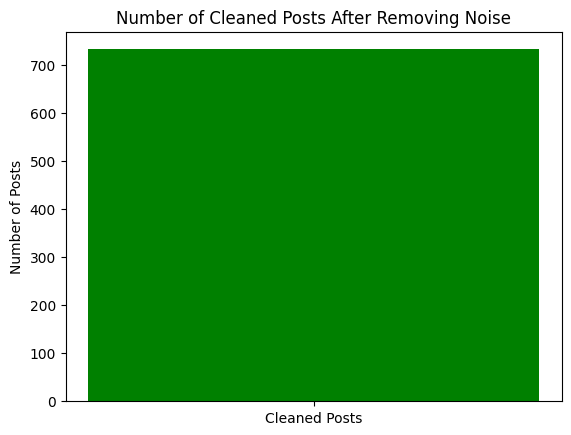

In [20]:
# goal 9: Impact of Data Quality: Noise (Spam or Irrelevant Posts) in Sentiment Analysis

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lower, regexp_replace

# Step 1: Initialize a Spark session
spark = SparkSession.builder.appName("DataQualityImpact").getOrCreate()

# Step 2: Load the CSV file into a DataFrame
csv_file_path = "C:\\Users\\S566638\\Downloads\\sentimentdataset.csv"  # Replace with the correct path
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Step 3: Clean noisy data by removing rows with empty or irrelevant content
df_cleaned = df.filter((col("Text").isNotNull()) & (col("Text") != ""))

# Step 4: Preprocess text (e.g., convert to lowercase, remove special characters)
df_cleaned = df_cleaned.withColumn("CleanedText", lower(col("Text")))
df_cleaned = df_cleaned.withColumn("CleanedText", regexp_replace(col("CleanedText"), "[^a-zA-Z0-9\\s]", ""))

# Show cleaned data
df_cleaned.show(5)

# Step 5: Visualize the count of cleaned data posts
import matplotlib.pyplot as plt

# Get the count of cleaned posts
cleaned_post_count = df_cleaned.count()

# Plotting the data
labels = ['Cleaned Posts']
values = [cleaned_post_count]

# Create a bar chart
plt.bar(labels, values, color='green')

# Add titles and labels
plt.title('Number of Cleaned Posts After Removing Noise')
plt.ylabel('Number of Posts')

# Show the plot
plt.show()


+-------------+-----+
|    Sentiment|count|
+-------------+-----+
|   Positive  |   44|
|         Joy |   42|
|  Excitement |   32|
| Contentment |   14|
|     Neutral |   14|
|       Happy |   14|
+-------------+-----+



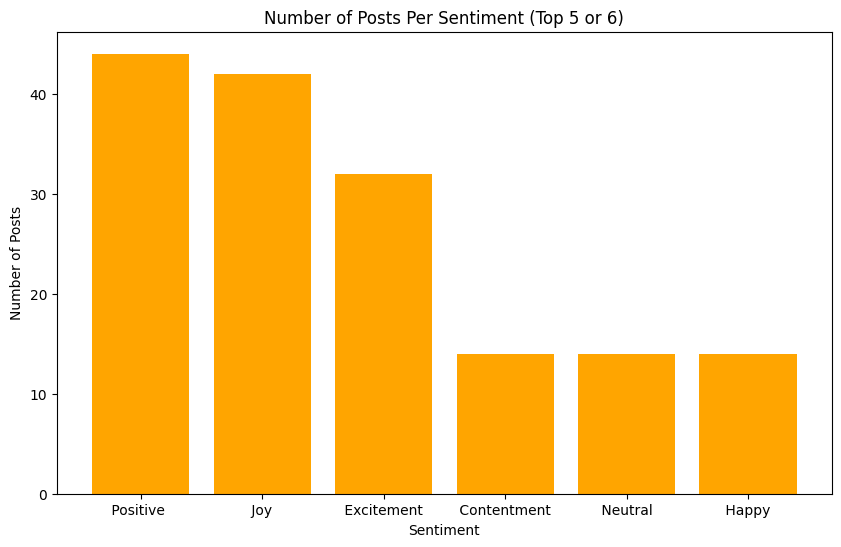

In [23]:
# goal 10 : Cost and efficency
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import matplotlib.pyplot as plt

# Step 1: Initialize a Spark session
spark = SparkSession.builder.appName("PostsPerSentimentBarChart").getOrCreate()

# Step 2: Load the CSV file into a DataFrame
csv_file_path = "C:\\Users\\S566638\\Downloads\\sentimentdataset.csv"  # Replace with the correct path
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Step 3: Optimize Spark operations by filtering and selecting required columns only
df_optimized = df.select("Sentiment", "Text", "Likes", "Retweets").filter(col("Text").isNotNull())

# Perform action to trigger the computation and check memory usage
df_optimized.cache()  # Cache data to optimize subsequent operations

# Step 4: Count posts by sentiment and limit to top 5 or 6 sentiments
df_sentiment_counts = df_optimized.groupBy("Sentiment").count().orderBy("count", ascending=False).limit(6)

# Show the result (this is an action to execute)
df_sentiment_counts.show()

# Step 5: Plot the number of posts for each sentiment
sentiment_data = df_sentiment_counts.collect()
sentiments = [row['Sentiment'] for row in sentiment_data]
counts = [row['count'] for row in sentiment_data]

# Plotting the data
plt.figure(figsize=(10, 6))
plt.bar(sentiments, counts, color='orange')

# Add titles and labels
plt.title('Number of Posts Per Sentiment (Top 5 or 6)')
plt.xlabel('Sentiment')
plt.ylabel('Number of Posts')

# Show the plot
plt.show()


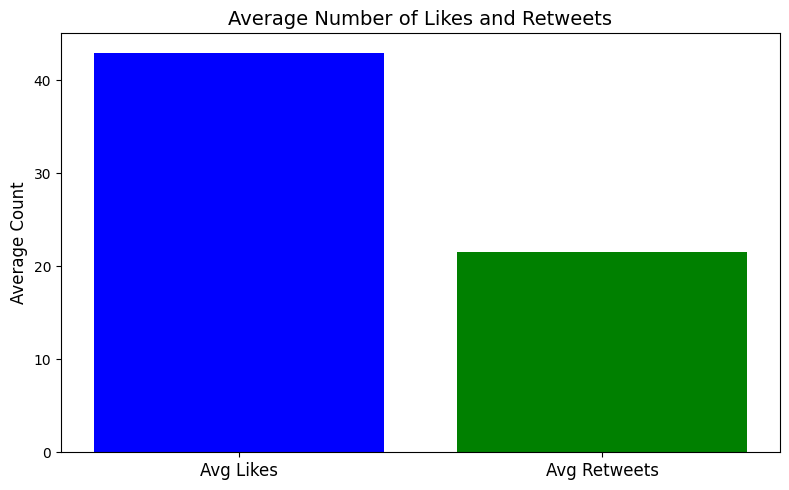

In [9]:
#goal 8: Calculate the Average Number of Likes and Retweets

# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt

# Step 1: Initialize a Spark session
spark = SparkSession.builder.appName("LikesAndRetweetsAnalysis").getOrCreate()

# Step 2: Load the CSV file into a DataFrame
csv_file_path = "C:\\Users\\S566638\\Downloads\\sentimentdataset.csv"  # Replace with the correct path
df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

# Step 3: Calculate the average number of likes and retweets
df_averages = df.agg(
    F.avg("Likes").alias("AvgLikes"),
    F.avg("Retweets").alias("AvgRetweets")
)

# Collect the result from PySpark DataFrame into a list
avg_values = df_averages.collect()

# Extract the values for AvgLikes and AvgRetweets
avg_likes = avg_values[0]['AvgLikes']
avg_retweets = avg_values[0]['AvgRetweets']

# Step 4: Visualize the data using Matplotlib
# Data for plotting
labels = ['Avg Likes', 'Avg Retweets']
values = [avg_likes, avg_retweets]

# Create a bar chart
plt.figure(figsize=(8, 5))
plt.bar(labels, values, color=['blue', 'green'])

# Add title and labels
plt.title('Average Number of Likes and Retweets', fontsize=14)
plt.ylabel('Average Count', fontsize=12)
plt.xticks(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()
